In [1]:
from matplotlib import image
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
import numpy 

%load_ext autoreload
%autoreload 2
torch.manual_seed(0)

from models_nf import MixedModelDensityEstimator, RealNVPDensityEstimatorLayer

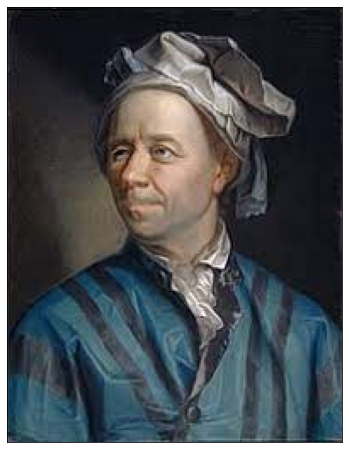

In [2]:
rgb = image.imread("euler.jpg")
figure = plt.figure(figsize = (12,8))
plt.tick_params(left=False,bottom=False,labelleft=False,labelbottom=False)
plt.imshow(rgb)
lines, columns = rgb.shape[:-1]

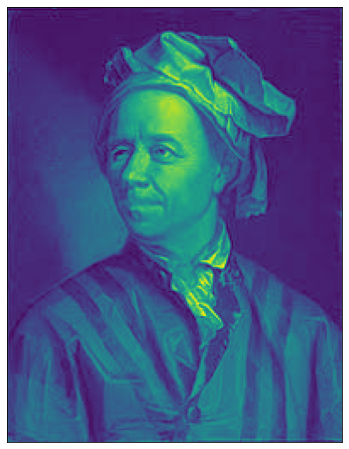

In [3]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])
grey = torch.tensor(rgb2gray(rgb))
figure = plt.figure(figsize = (12,8))
plt.tick_params(left=False,bottom=False,labelleft=False,labelbottom=False)
plt.imshow(grey)

In [4]:
#Sample data according to image
vector_density = grey.flatten()
vector_density = vector_density/torch.sum(vector_density)
lines, columns = grey.shape
num_samples = 300000
cat = torch.distributions.Categorical(probs = vector_density)
categorical_samples = cat.sample([num_samples])
target_samples = torch.cat([((categorical_samples//columns  + torch.rand([num_samples]))/lines).unsqueeze(-1), ((categorical_samples%columns + torch.rand([num_samples]))/columns).unsqueeze(-1)], dim = -1)

C:\Users\EA264728\AppData\Local\Temp\ipykernel_12848\2620298382.py:8: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  target_samples = torch.cat([((categorical_samples//columns  + torch.rand([num_samples]))/lines).unsqueeze(-1), ((categorical_samples%columns + torch.rand([num_samples]))/columns).unsqueeze(-1)], dim = -1)


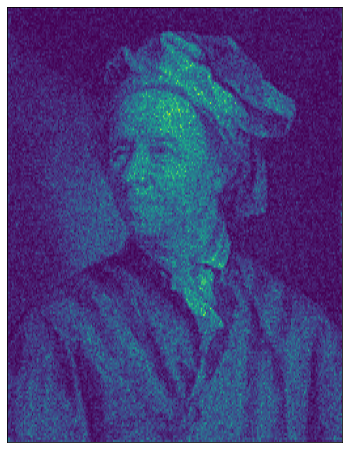

In [5]:
hist_target_samples, x_edges, y_edges = numpy.histogram2d(target_samples[:,1].numpy(), target_samples[:, 0].numpy(), bins = (lines, columns),range = [[0, 1],[0,1]])
figure = plt.figure(figsize = (12,8))
plt.tick_params(left=False,bottom=False,labelleft=False,labelbottom=False)
plt.imshow(torch.flip(torch.flip(torch.tensor(hist_target_samples).T,[0,1]),[0,1]),extent = [0,columns,0, lines])

In [ ]:
from models_nf import RealNVP, NeuralSplineFlow
real_nvp = RealNVP(target_samples, 20, None, None)
print(real_nvp.compute_number_params())
epochs = 50
batch_size= 3000
real_nvp.train(epochs, batch_size)

132540


  0%|                                                                                                                                                              | 0/50 [00:00<?, ?it/s]

In [19]:
samples = real_nvp.model.sample(num_samples = 2)
print(samples)
plt.scatter(samples[:,0],samples[:,1])

(tensor([[0.9912, 0.5843],
        [0.6342, 0.7632]], grad_fn=<CatBackward0>), tensor([0.0540, 0.0840], grad_fn=<SubBackward0>))


TypeError: tuple indices must be integers or slices, not tuple

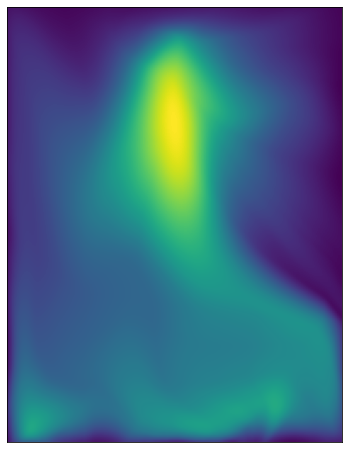

In [10]:
with torch.no_grad():
    grid = torch.cartesian_prod(torch.linspace(0,1,lines),torch.linspace(0,1, columns))
    density = torch.exp(real_nvp.model.log_prob(grid)).reshape(lines,columns).T
    figure = plt.figure(figsize = (12,8))
    plt.tick_params(left=False,bottom=False,labelleft=False,labelbottom=False)
    plt.imshow(torch.flip(torch.flip(density.T,[0,1]),[0,1]),extent = [0,columns,0, lines])

In [ ]:
num_samples = target_samples.shape[0]
epochs =1000
batch_size = 3000
number_layer = 2
structure = [[RealNVPDensityEstimatorLayer, [128,128,128]] for i in range(number_layer)]
realnvp = MixedModelDensityEstimator(target_samples,structure)
print(realnvp.compute_number_params())
realnvp.train(epochs, batch_size)

67848


 43%|█████████████████████████████████████████████████▎                                                                | 433/1000 [08:58<13:02,  1.38s/it, loss = -0.036205 ; device: cpu]

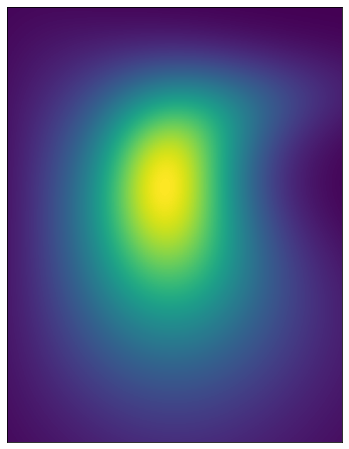

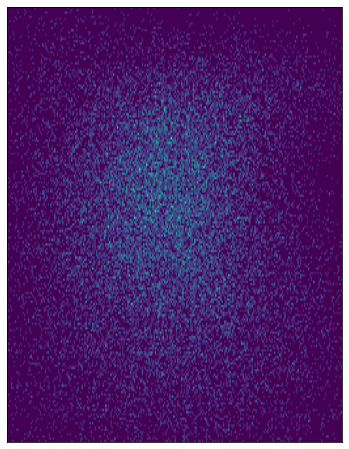

In [13]:
with torch.no_grad():
    grid = torch.cartesian_prod(torch.linspace(0,1,lines),torch.linspace(0,1, columns))
    density = torch.exp(realnvp.log_density(grid)).reshape(lines,columns).T
    figure = plt.figure(figsize = (12,8))
    plt.tick_params(left=False,bottom=False,labelleft=False,labelbottom=False)
    plt.imshow(torch.flip(torch.flip(density.T,[0,1]),[0,1]),extent = [0,columns,0, lines])
    dif_samples = realnvp.sample_model(target_samples.shape[0])
    hist_dif_samples, x_edges, y_edges = numpy.histogram2d(dif_samples[:,1].numpy(), dif_samples[:, 0].numpy(), bins = (lines, columns),range = [[0, 1],[0,1]])
    figure = plt.figure(figsize = (12,8))
    plt.tick_params(left=False,bottom=False,labelleft=False,labelbottom=False)
    plt.imshow(torch.flip(torch.flip(torch.tensor(hist_dif_samples).T,[0,1]),[0,1]),extent = [0,columns,0, lines])